In [1]:
# todo:
#

In [1]:
%matplotlib inline
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

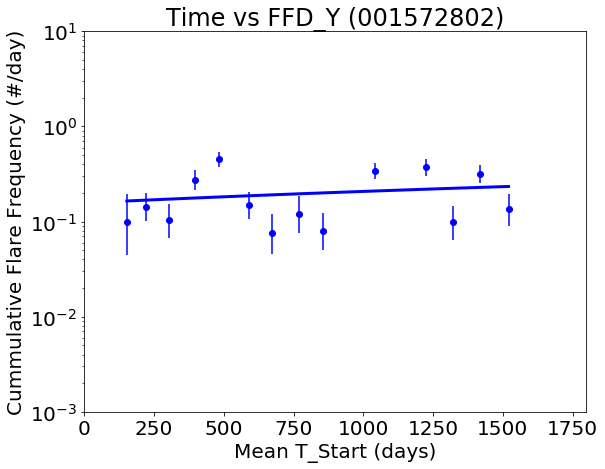

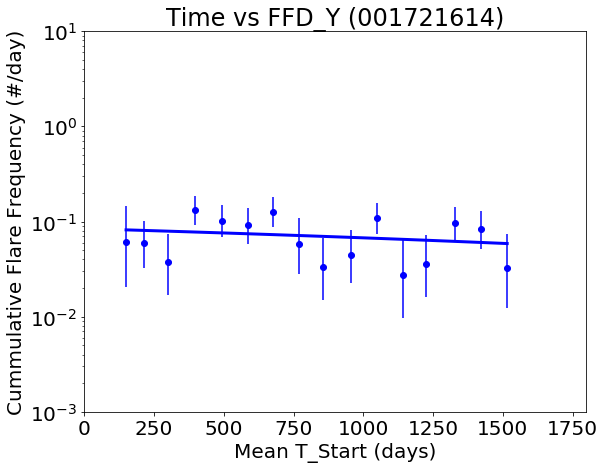

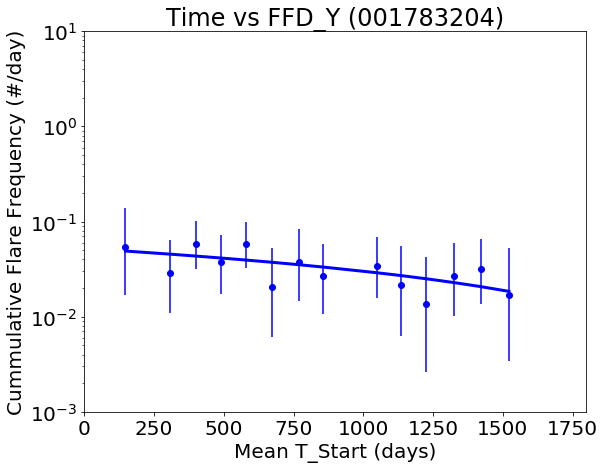

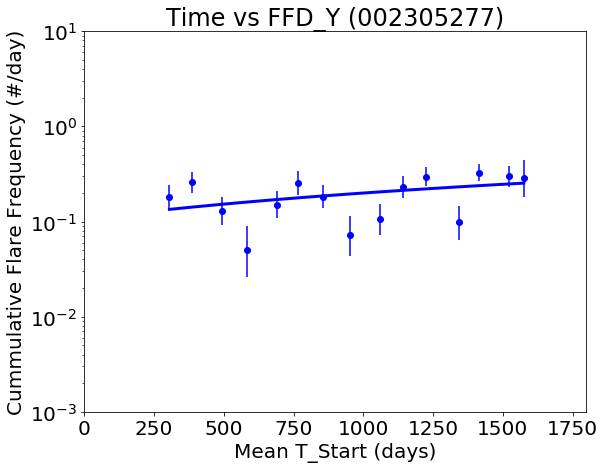

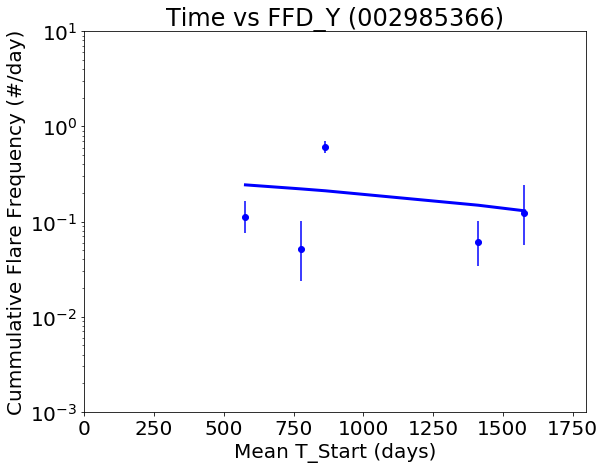

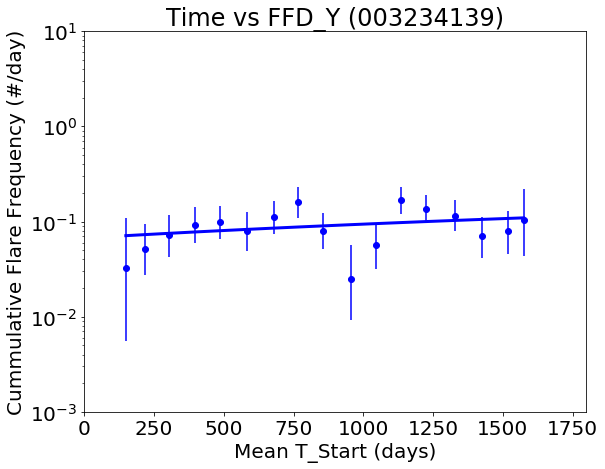

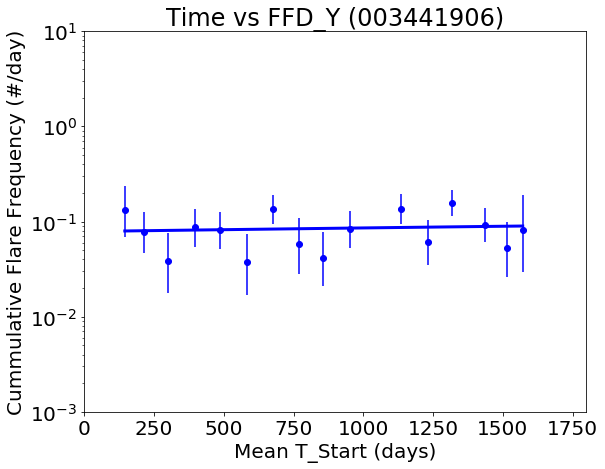

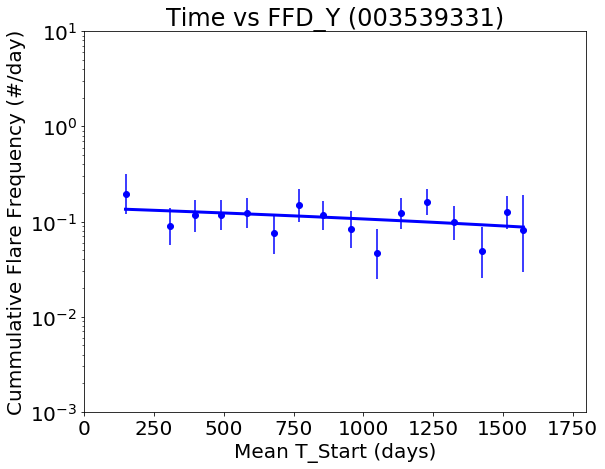

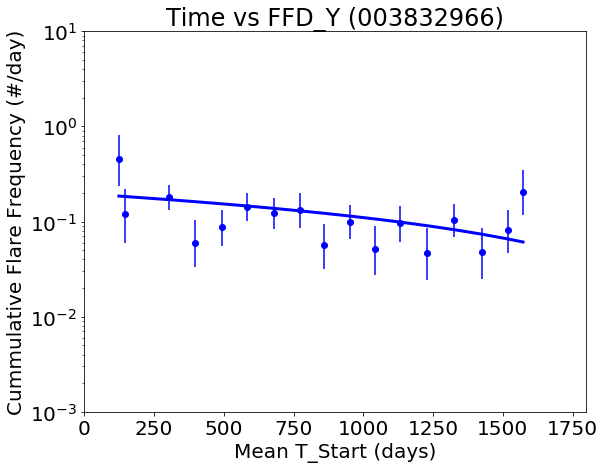

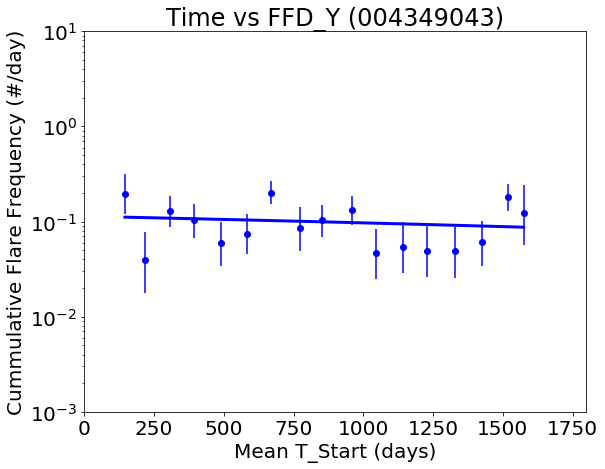

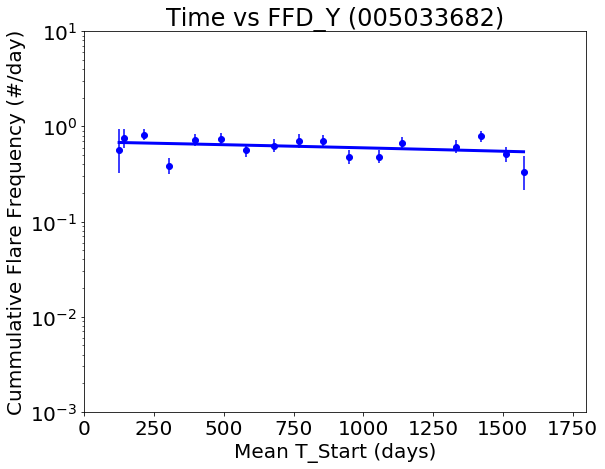

In [56]:
#Specify a fixed log-energy value. Plot the mean-time vs FFD_y values = plot time vs flare rate per day

targets = open("KICS/targets.txt", "r") # a file containing all the KICs we want to plot
EPOINT = 0 # need to fix this

logEnergyConstant = 1.5 + EPOINT # the fixed energy value

np.seterr(invalid='ignore') #ignore the Nans
plt.rcParams.update({'font.size': 20}) #font size
cmap = plt.cm.Spectral # color scheme -- visible color spectrum, starting with red as the earliest
names=("t_start", "t_stop", "t_peak", "amplitude", "FWHM", "duration", "t_peak_aflare1", 
       "t_FWHM_aflare1", "amplitude_aflare1", "flare_chisq", "KS_d_model", "KS_p_model", 
       "KS_d_cont", "KS_p_cont", "Equiv_Dur", "ED68i", "ED90i")

for line in targets: #going through each KIC
    
    KIC = line.rstrip('\n') #stripping the return off each line
    files = glob('KICS/'+KIC+"/*.flare") #Glob all of the files in the directory - get all flares for a star
    
    plt.figure(figsize=(9,7))
    plt.title("Time vs FFD_Y ("+KIC+')')
    plt.ylabel("Cummulative Flare Frequency (#/day)")
    plt.xlabel("Mean T_Start (days)")
    plt.yscale('log')
    plt.ylim([0.001,10])
    plt.xlim([0,1800])
    time = []
    frequency = []
    
    for x in range(len(files)):

        toteDur = pd.read_table(files[x], skiprows=5, nrows=1, header=None, 
                                delim_whitespace=True, usecols=(7,)
                               ).iloc[0].values[0]  #getting the total duration of each file

        df = pd.read_table(files[x], comment="#", delimiter=",", names=names)
        energy = df['Equiv_Dur'] #This is the energy column of the flare data
        sort = np.argsort(energy) #get indices that would sort the energy array


        ffd_xEnergy = np.log10(energy[sort][::-1]) + EPOINT #log the reverse of sorted energy
        ffd_yFrequency = (np.arange(1, len(ffd_xEnergy)+1, 1))/toteDur #get evenly spaced intervals, divide by totedur to get flares/day

        if(np.amax(ffd_xEnergy) >= logEnergyConstant >= np.amin(ffd_xEnergy)): #checking that the energy constant isn't out of bound,
                                                                               #otherwise, interpolate doesn't work

            ok68 = ffd_xEnergy >= np.log10(np.median(df['ED68i'])) + EPOINT #use ED68i to get indices of useful data, ignore the junk

            meanstart = np.sum(df['t_start'])/len(df['t_start']) #finding the mean time for a file
     
            if any(ok68): #checking if ok68 contains at least one 'true'
                
                ffd_yForMeanstart = np.interp(logEnergyConstant, ffd_xEnergy[ok68][::-1], ffd_yFrequency[ok68][::-1])#interpolating the ffd_y

                time.append(meanstart) #making lists so we can fit a line later
                frequency.append(ffd_yForMeanstart)
                
                
                toteFlare = ffd_yForMeanstart * toteDur #calculating error bars: multiplying the frequency by total duration to get total flare #   
                
                err_dn = (np.abs(toteFlare * (1.-1./(9. * toteFlare)-1./(3.*np.sqrt(toteFlare)))**3.-toteFlare))/toteDur
                err_up = (np.sqrt(toteFlare + 0.75) + 1.0)/toteDur

                plt.errorbar(meanstart, ffd_yForMeanstart, yerr = [[err_dn], [err_up]], fmt='bo', markersize=6)#plotting error
    
    
    slope, intercept = np.polyfit(time, frequency, 1)
    line_y = [slope * i + intercept for i in time]
    plt.plot(time, line_y, 'b',  lw=3,) #plotting a best fit line
    
    #plt.savefig('time-vs-ffd_y-plot/'+KIC+'_vs_time.png')

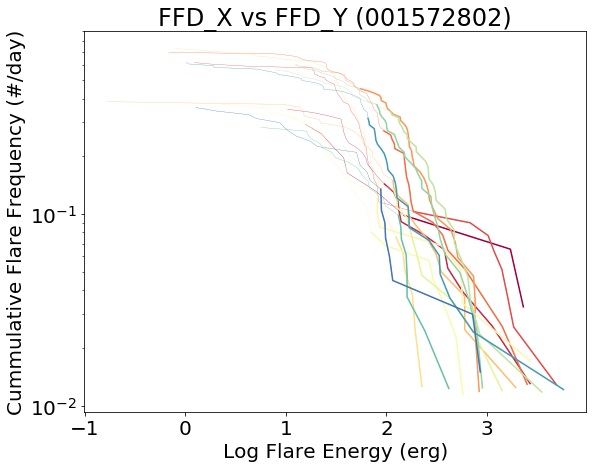

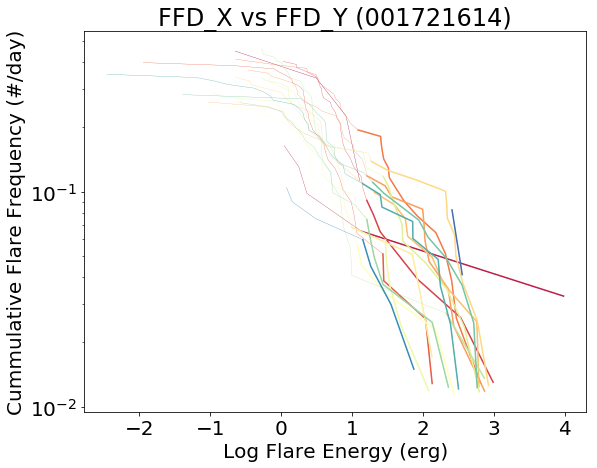

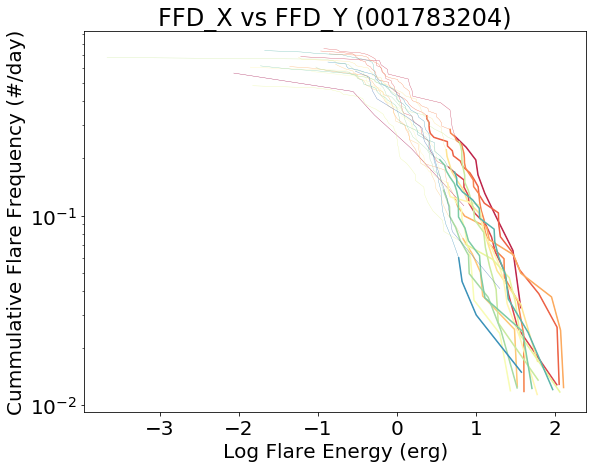

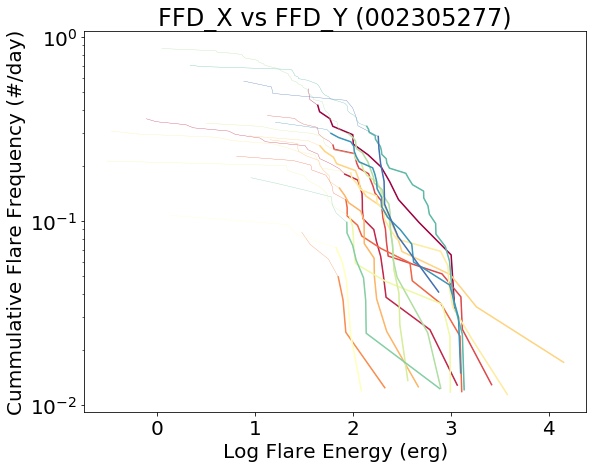

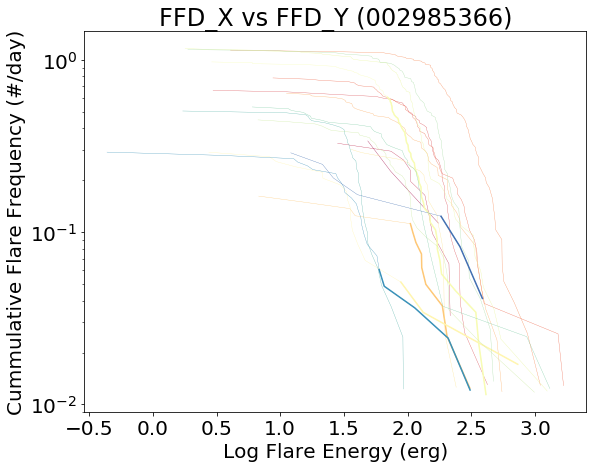

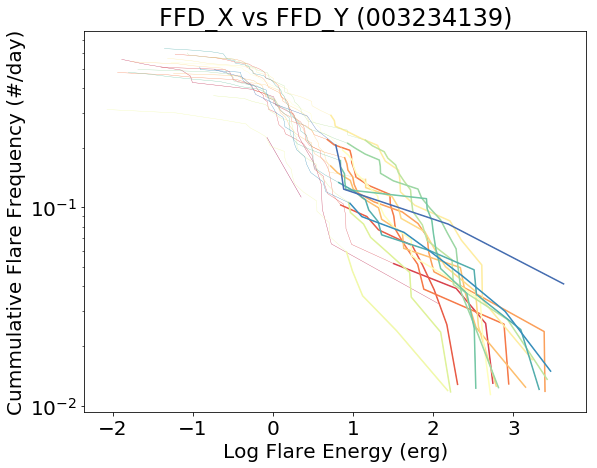

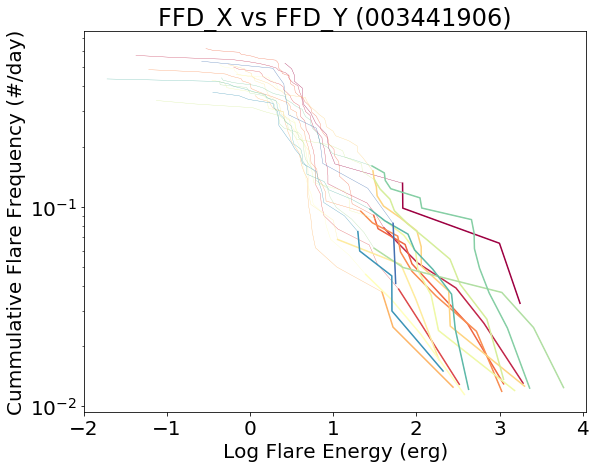

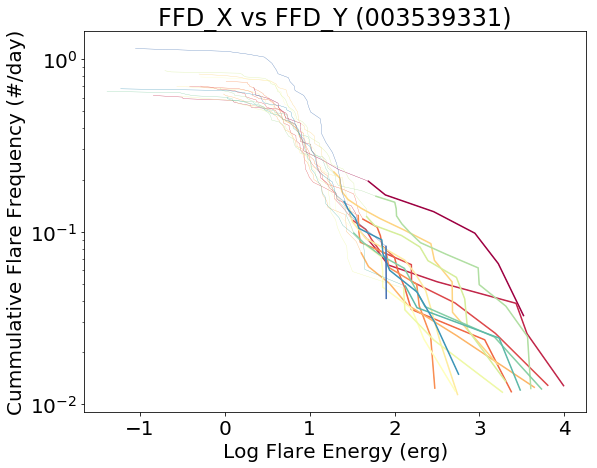

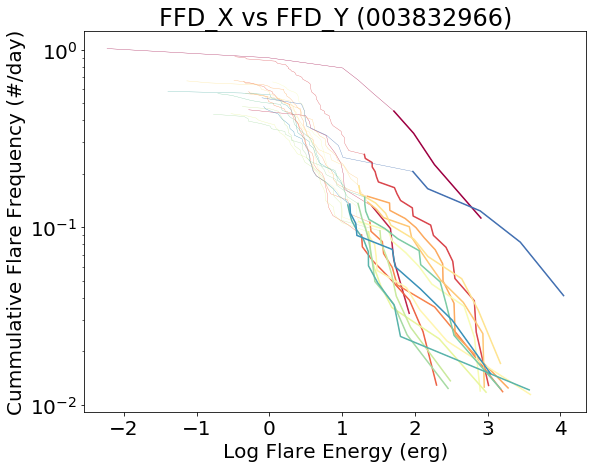

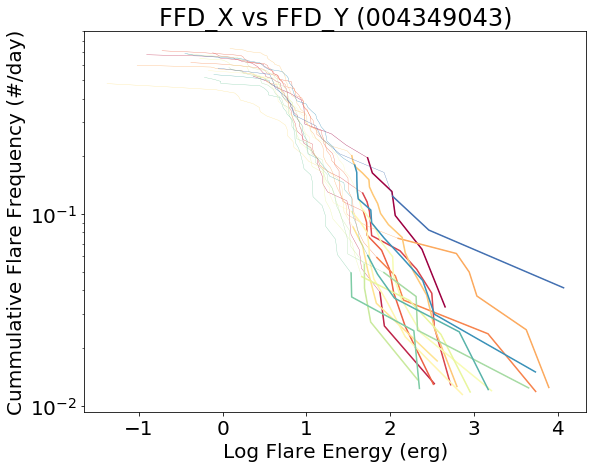

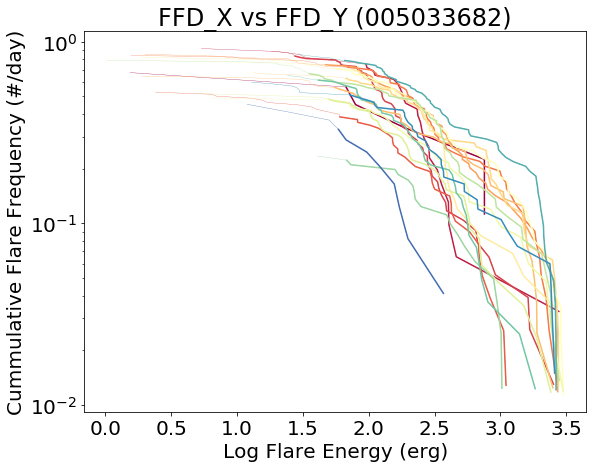

In [57]:
#plotting a reverse cummulative sum for a single KIC# number, hoping for a smooth change in frequency over time
#plotting all of the data, with data below the ED68i cutoff being the thinner lines

targets = open("KICs/targets.txt", "r") # a file containing all the KICs we want to plot
EPOINT = 0 # need to fix this

np.seterr(invalid='ignore') #ignore the Nans
plt.rcParams.update({'font.size': 20}) #font size
cmap = plt.cm.Spectral # color scheme -- visible color spectrum, starting with red as the earliest
names=("t_start", "t_stop", "t_peak", "amplitude", "FWHM", "duration", "t_peak_aflare1", 
       "t_FWHM_aflare1", "amplitude_aflare1", "flare_chisq", "KS_d_model", "KS_p_model", 
       "KS_d_cont", "KS_p_cont", "Equiv_Dur", "ED68i", "ED90i")

for line in targets: #going through each KIC
    
    KIC = line.rstrip('\n') #stripping the return off each line
    files = glob('KICs/'+KIC+"/*.flare") #Glob all of the files in the directory - get all flares for a star
    
    plt.figure(figsize=(9,7))
    plt.title("FFD_X vs FFD_Y ("+KIC+')')
    plt.ylabel("Cummulative Flare Frequency (#/day)")
    plt.xlabel("Log Flare Energy (erg)")
    plt.yscale('log')

    for x in range(len(files)):

        toteDur = pd.read_table(files[x], skiprows=5, nrows=1, header=None, 
                                delim_whitespace=True, usecols=(7,)
                               ).iloc[0].values[0]  #getting the total duration of each file
                
        df = pd.read_table(files[x], comment="#", delimiter=",", names=names)
        energy = df['Equiv_Dur'] #This is the energy column of the flare data
        sort = np.argsort(energy) #get indices that would sort the energy array

        ffd_xEnergy = np.log10(energy[sort][::-1]) + EPOINT #log the reverse of sorted energy
        ffd_yFrequency = (np.arange(1, len(ffd_xEnergy)+1, 1))/toteDur #get evenly spaced intervals, divide by totedur to get flares/day

        ok68 = ffd_xEnergy >= np.log10(np.median(df['ED68i'])) + EPOINT #use ED68i to get indices of useful data, ignore the junk
    
        plt.plot(ffd_xEnergy[ok68], ffd_yFrequency[ok68], c = cmap(x/float(len(files)))) #only plotting significant data, using ok68
        plt.plot(ffd_xEnergy, ffd_yFrequency, lw = 0.3, c = cmap(x/float(len(files)))) #plotting all data

    
        err_dn =  []
        err_up = []
        
        for y in range (len(ffd_yFrequency)):
            
            toteFlare = toteDur*ffd_yFrequency[y]
            err_dn.append((np.abs(toteFlare * (1.-1./(9. * toteFlare)-1./(3.*np.sqrt(toteFlare)))**3.-toteFlare))/toteDur)
            err_up.append((np.sqrt(toteFlare + 0.75) + 1.0)/toteDur)
            
        #plt.errorbar(ffd_xEnergy, ffd_yFrequency, yerr = [err_dn, err_up], c = 'black', elinewidth=.3, fmt='o', markersize = .75)
 

        
    #plt.savefig('ffd_x-vs-ffd_y-whole-plot/'+KIC+'_whole_FFD.png')


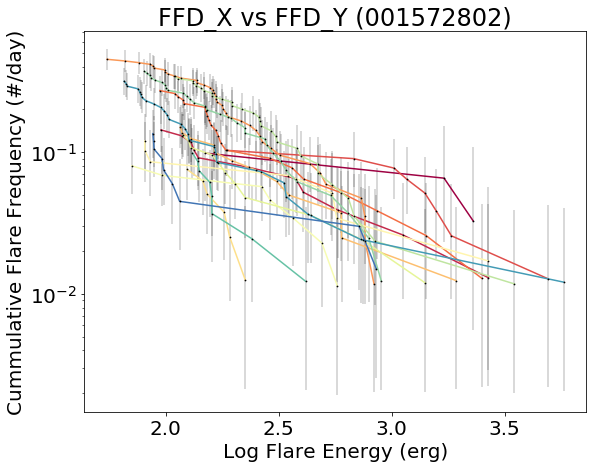

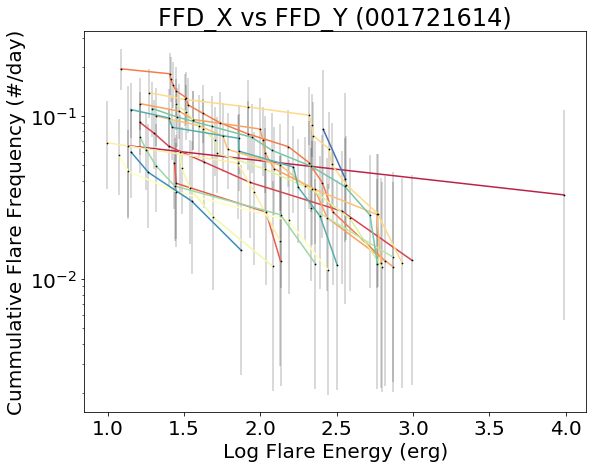

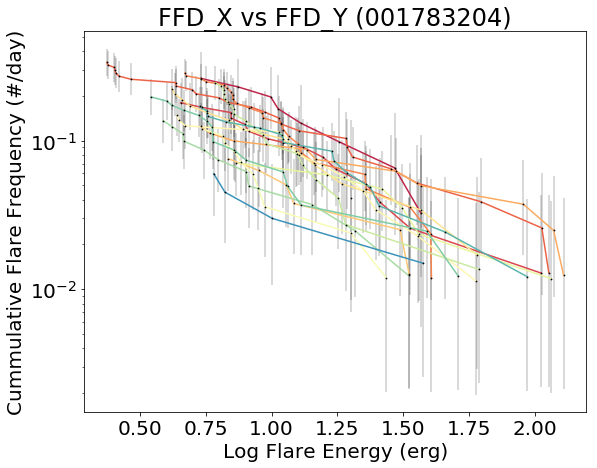

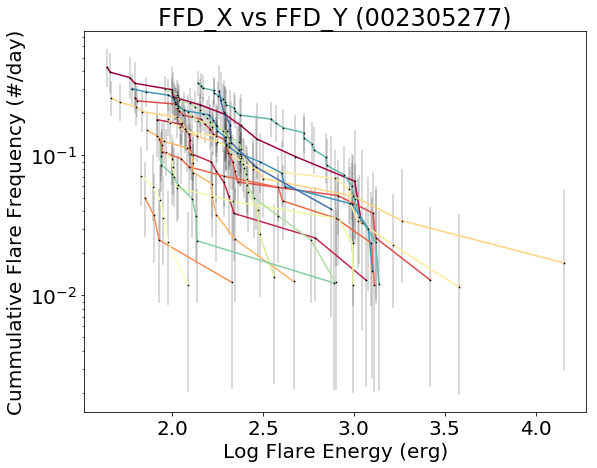

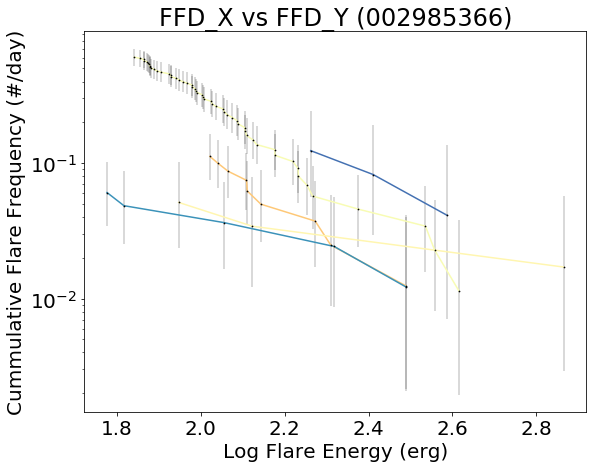

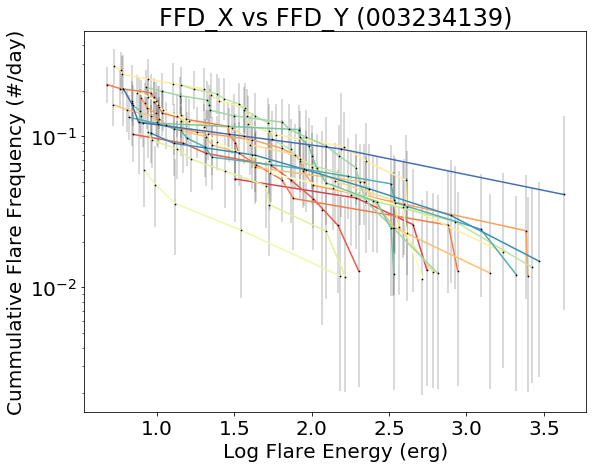

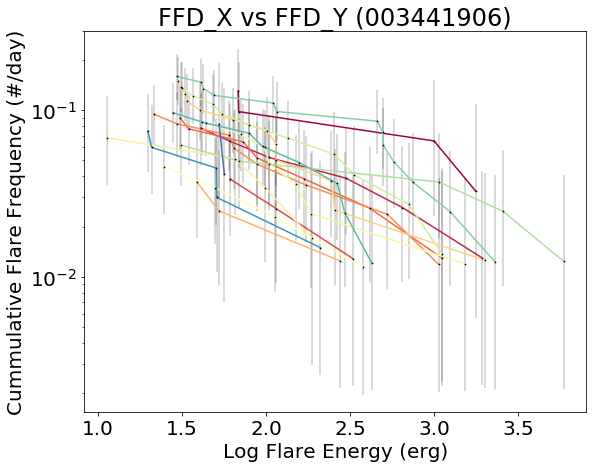

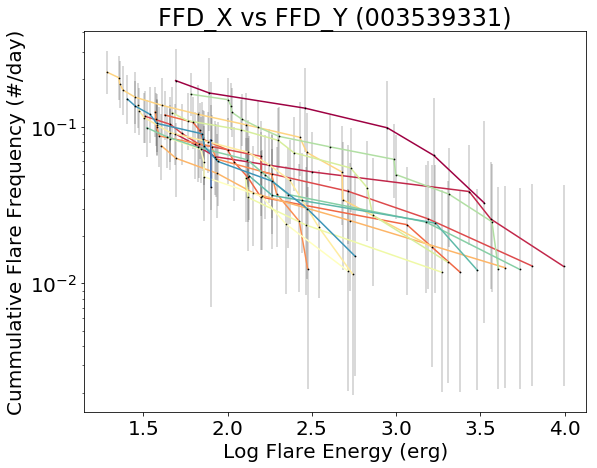

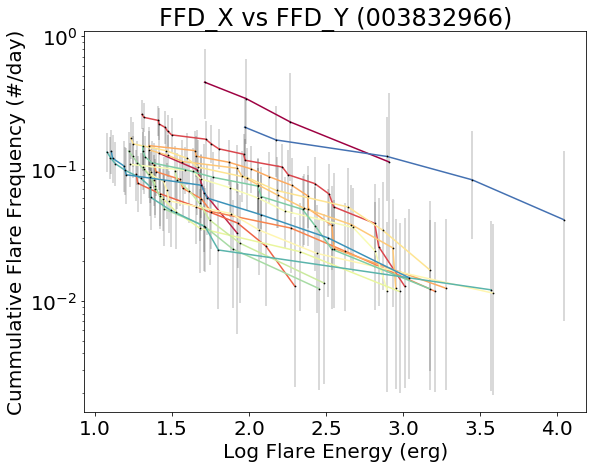

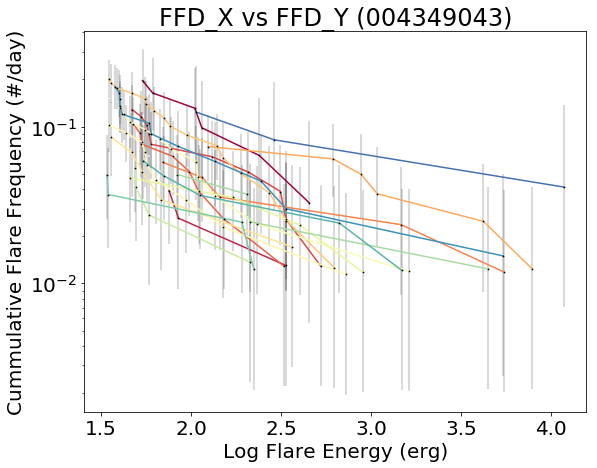

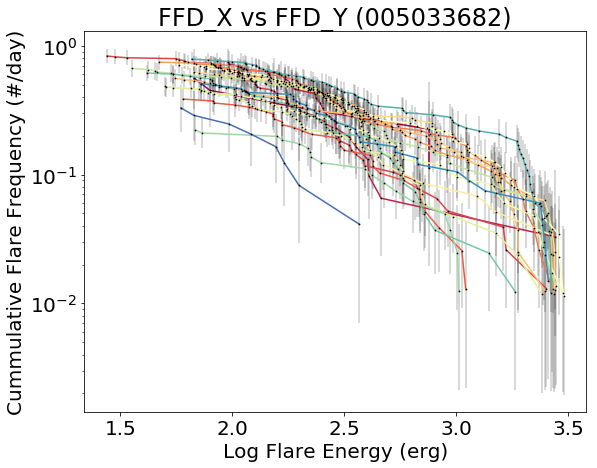

In [58]:
#plotting a reverse cummulative sum for a single KIC# number (using ED68i cutoff), hoping for a smooth change in frequency over time

targets = open("KICs/targets.txt", "r") # a file containing all the KICs we want to plot
EPOINT = 0 # need to fix this

np.seterr(invalid='ignore') #ignore the Nans
plt.rcParams.update({'font.size': 20}) #font size
cmap = plt.cm.Spectral # color scheme -- visible color spectrum, starting with red as the earliest
names=("t_start", "t_stop", "t_peak", "amplitude", "FWHM", "duration", "t_peak_aflare1", 
       "t_FWHM_aflare1", "amplitude_aflare1", "flare_chisq", "KS_d_model", "KS_p_model", 
       "KS_d_cont", "KS_p_cont", "Equiv_Dur", "ED68i", "ED90i")

for line in targets: #going through each KIC
    
    KIC = line.rstrip('\n') #stripping the return off each line
    files = glob('KICs/'+KIC+"/*.flare") #Glob all of the files in the directory - get all flares for a star
    
    plt.figure(figsize=(9,7))
    plt.title("FFD_X vs FFD_Y ("+KIC+')')
    plt.ylabel("Cummulative Flare Frequency (#/day)")
    plt.xlabel("Log Flare Energy (erg)")
    plt.yscale('log')

    for x in range(len(files)):

        toteDur = pd.read_table(files[x], skiprows=5, nrows=1, header=None, 
                                delim_whitespace=True, usecols=(7,)
                               ).iloc[0].values[0]  #getting the total duration of each file
                
        df = pd.read_table(files[x], comment="#", delimiter=",", names=names)
        energy = df['Equiv_Dur'] #This is the energy column of the flare data
        sort = np.argsort(energy) #get indices that would sort the energy array

        
        
        ffd_xEnergy = np.log10(energy[sort][::-1]) + EPOINT #log the reverse of sorted energy
        ffd_yFrequency = (np.arange(1, len(ffd_xEnergy)+1, 1))/toteDur #get evenly spaced intervals, divide by totedur to get flares/day

        ok68 = ffd_xEnergy >= np.log10(np.median(df['ED68i'])) + EPOINT #use ED68i to get indices of useful data, ignore the junk
    
        plt.plot(ffd_xEnergy[ok68], ffd_yFrequency[ok68], c = cmap(x/float(len(files)))) #only plotting significant data, using ok68

    
        err_dn =  []
        err_up = []
        
        for y in range (len(ffd_yFrequency[ok68])): #calculating the error bars for each point

            toteFlare = toteDur*ffd_yFrequency[ok68][y]
            err_dn.append((np.abs(toteFlare * (1.-1./(9. * toteFlare)-1./(3.*np.sqrt(toteFlare)))**3.-toteFlare))/toteDur)
            err_up.append((np.sqrt(toteFlare + 0.75) + 1.0)/toteDur)
           
        plt.errorbar(ffd_xEnergy[ok68], ffd_yFrequency[ok68], yerr = [err_dn, err_up], c = 'black', elinewidth=.3, fmt='o', markersize = .75)
        

    #plt.savefig('ffd_x-vs-ffd_y-sig-plot/'+KIC+'_sig_FFD.png')

#

In [ ]:
##to be used from terminal
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob

#a bunch of checks, looking for correct input
if(len(sys.argv) == 1 or (sys.argv[1] == "help")):
    print("input: 'flaregraphs.py'   'KIC_number_targets.txt' 'evf'             for an energy vs frequency plot")
    print("input: 'flaregraphs.py'   'KIC_number_targets.txt' 'evfs'            for an energy vs frequency plot, plotting only the data above the ED68i cutoff")
    print("input: 'flaregraphs.py'   'KIC_number_targets.txt' 'tvf' 'energy#'   for a time vs frequency plot, fixed at the specified log-energy value")
    sys.exit()

try:
    file = sys.argv[1]
    targets = open(file, "r") # a file containing all the KICs we want to plot
except:
    print("Error: Cannot open "+file+". Type 'help' for a list of possible commands")
    sys.exit()

if((len(sys.argv) == 2) or (not((sys.argv[2] == "evfs") or (sys.argv[2] == "evf") or (sys.argv[2] == "tvf")))):
    print("Error: Unrecognized command. Type 'help' for a list of possible commands.")
    sys.exit()




np.seterr(invalid='ignore') #ignore the Nans
plt.rcParams.update({'font.size': 20}) #font size
cmap = plt.cm.Spectral # color scheme -- visible color spectrum, starting with red as the earliest
names=("t_start", "t_stop", "t_peak", "amplitude", "FWHM", "duration", "t_peak_aflare1",
       "t_FWHM_aflare1", "amplitude_aflare1", "flare_chisq", "KS_d_model", "KS_p_model",
       "KS_d_cont", "KS_p_cont", "Equiv_Dur", "ED68i", "ED90i")

EPOINT = 0 # need to fix this



def plotEVF(): #plotting energy vs frequency

    for line in targets: #going through each KIC

        KIC = line.rstrip('\n') #stripping the return off each line
        files = glob('KICs/'+KIC+"/*.flare") #Glob all of the files in the directory - get all flares for a star

        plt.figure(figsize=(9,7))
        plt.title("FFD_X vs FFD_Y ("+KIC+')')
        plt.ylabel("Cummulative Flare Frequency (#/day)")
        plt.xlabel("Log Flare Energy (erg)")
        plt.yscale('log')

        for x in range(len(files)):

            toteDur = pd.read_table(files[x], skiprows=5, nrows=1, header=None,
                                    delim_whitespace=True, usecols=(7,)
                                   ).iloc[0].values[0]  #getting the total duration of each file

            df = pd.read_table(files[x], comment="#", delimiter=",", names=names)
            energy = df['Equiv_Dur'] #This is the energy column of the flare data
            sort = np.argsort(energy) #get indices that would sort the energy array

            ffd_xEnergy = np.log10(energy[sort][::-1]) + EPOINT #log the reverse of sorted energy
            ffd_yFrequency = (np.arange(1, len(ffd_xEnergy)+1, 1))/toteDur #get evenly spaced intervals, divide by totedur to get flares/day

            ok68 = ffd_xEnergy >= np.log10(np.median(df['ED68i'])) + EPOINT #use ED68i to get indices of useful data, ignore the junk

            plt.plot(ffd_xEnergy, ffd_yFrequency, lw = .35, c = cmap(x/float(len(files)))) #all data
            plt.plot(ffd_xEnergy[ok68], ffd_yFrequency[ok68], c = cmap(x/float(len(files)))) #significant data

        #plt.savefig('ffd_x-vs-ffd_y-whole-plot/'+KIC+'_whole_FFD.png')


    plt.show()


def plotEVFsig(): #plotting energy vs frequency but only for significant data

    for line in targets: #going through each KIC

        KIC = line.rstrip('\n') #stripping the return off each line
        files = glob('KICs/'+KIC+"/*.flare") #Glob all of the files in the directory - get all flares for a star

        plt.figure(figsize=(9,7))
        plt.title("FFD_X vs FFD_Y ("+KIC+')')
        plt.ylabel("Cummulative Flare Frequency (#/day)")
        plt.xlabel("Log Flare Energy (erg)")
        plt.yscale('log')

        for x in range(len(files)):

            toteDur = pd.read_table(files[x], skiprows=5, nrows=1, header=None,
                                    delim_whitespace=True, usecols=(7,)
                                   ).iloc[0].values[0]  #getting the total duration of each file

            df = pd.read_table(files[x], comment="#", delimiter=",", names=names)
            energy = df['Equiv_Dur'] #This is the energy column of the flare data
            sort = np.argsort(energy) #get indices that would sort the energy array

            ffd_xEnergy = np.log10(energy[sort][::-1]) + EPOINT #log the reverse of sorted energy
            ffd_yFrequency = (np.arange(1, len(ffd_xEnergy)+1, 1))/toteDur #get evenly spaced intervals, divide by totedur to get flares/day

            ok68 = ffd_xEnergy >= np.log10(np.median(df['ED68i'])) + EPOINT #use ED68i to get indices of useful data, ignore the junk

            plt.plot(ffd_xEnergy[ok68], ffd_yFrequency[ok68], c = cmap(x/float(len(files)))) #significant data

        #plt.savefig('ffd_x-vs-ffd_y-sig-plot/'+KIC+'_sig_FFD.png')


    plt.show()



def plotTVF(logEnergyConstant): #plotting time vs frequency

    for line in targets: #going through each KIC

        KIC = line.rstrip('\n') #stripping the return off each line
        files = glob('KICS/'+KIC+"/*.flare") #Glob all of the files in the directory - get all flares for a star

        plt.figure(figsize=(9,7))
        plt.title("Time vs FFD_Y ("+KIC+')')
        plt.ylabel("Cummulative Flare Frequency (#/day)")
        plt.xlabel("Mean T_Start (days)")
        plt.yscale('log')
        plt.ylim([0.001,10])
        plt.xlim([0,1800])

        for x in range(len(files)):

            toteDur = pd.read_table(files[x], skiprows=5, nrows=1, header=None,
                                    delim_whitespace=True, usecols=(7,)
                                   ).iloc[0].values[0]  #getting the total duration of each file

            df = pd.read_table(files[x], comment="#", delimiter=",", names=names)
            energy = df['Equiv_Dur'] #This is the energy column of the flare data
            sort = np.argsort(energy) #get indices that would sort the energy array


            ffd_xEnergy = np.log10(energy[sort][::-1]) + EPOINT #log the reverse of sorted energy
            ffd_yFrequency = (np.arange(1, len(ffd_xEnergy)+1, 1))/toteDur #get evenly spaced intervals, divide by totedur to get flares/day

            if(np.amax(ffd_xEnergy) >= logEnergyConstant >= np.amin(ffd_xEnergy)): #checking that the energy constant isn't out of bound,
                                                                                   #otherwise, interpolate doesn't work

                ok68 = ffd_xEnergy >= np.log10(np.median(df['ED68i'])) + EPOINT #use ED68i to get indices of useful data, ignore the junk

                meanstart = np.sum(df['t_start'])/len(df['t_start']) #finding the mean time for a file

                if any(ok68): #checking if ok68 contains at least one 'true'
                    ffd_yForMeanstart = np.interp(logEnergyConstant, ffd_xEnergy[ok68][::-1], ffd_yFrequency[ok68][::-1])#interpolating the ffd_y

                    plt.scatter(meanstart, ffd_yForMeanstart, s=40, c = cmap(x/float(len(files))))

        #plt.savefig('time-vs-ffd_y-plot/'+KIC+'_E='+str(logEnergyConstant)+'_vs_time.png')

    plt.show()



if(sys.argv[2] == "evf"): #plotting energy vs frequency
    plotEVF()

elif(sys.argv[2] == "evfs"): #plotting significant energy vs frequency
    plotEVFsig()

elif(sys.argv[2] == "tvf"): #plotting time vs frequency
    try:
        logEnergyConstant = float(sys.argv[3]) + EPOINT # the fixed energy value
    except:
        print("Error: Cannot convert fixed-energy value to a float OR no fixed-energy value was provided . Type 'help' for a list of possible commands.")
        sys.exit()
    plotTVF(logEnergyConstant)
